In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import joblib as jl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedShuffleSplit

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

root = 'dl'

Using TensorFlow backend.


# Load raw data

In [2]:
labels = pd.read_csv('../../tmp/1_METONLY_vs_METX/matched_CEM_table.csv', header=0).rename({'Unnamed: 0': 'PIN'}, axis=1)[['PIN', 'CLASS']].set_index('PIN')
labels.head()

,CLASS
PIN,
568483,1
923748,0
2035328,0
2239386,1
2244533,1


In [3]:
data = pd.read_csv('../../tmp/raw_sequences2.csv', header=0, index_col=0).loc[labels.index, 'seq']
df = pd.DataFrame(columns=['Seq', 'Class'], index=data.index)
df.loc[:, 'Seq'] = data
df.loc[:, 'Class'] = labels['CLASS']
df.head()

,Seq,Class
PIN,,
568483,1099 0 23 1 725 0 1099 0 1099 0 1099 0 1099 0 ...,1
923748,6665 0 6507 0 6651 0 1096 0 105 0 5680 2 1099 ...,0
2035328,6653 0 7499 0 6651 0 6655 0 6660 0 6671 0 6656...,0
2239386,1099 0 23 3 7392 0 6656 0 6651 0 6655 0 6653 0...,1
2244533,1099 0 23 2 23 0 1099 0 7392 0 6650 0 6656 0 6...,1


# Seq2Tokens

In [4]:
# Define tokenizer object
tokenizer = Tokenizer(char_level=False, lower=False, split=' ')

# Fit on corpus and extract tokenized sequences
tokenizer.fit_on_texts(df['Seq'])
n_feat = len(tokenizer.word_index.keys())
print(n_feat)
seq = tokenizer.texts_to_sequences(df['Seq'])

# Pad tokenized sequences
lengths = [len(x) for x in seq]
maxlen = int(np.percentile(lengths, 95))
p_seq = pad_sequences(seq, maxlen=maxlen)
print(p_seq.shape)

1293
(11744, 889)


# Training - Validation - Test split

In [5]:
# Full dataset
y = df['Class'].ravel()
X = p_seq

# Learn / Test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
learn_idx, test_idx = next(sss.split(X, y))

X_learn, y_learn = X[learn_idx, :], y[learn_idx]
X_test, y_test = X[test_idx, :], y[test_idx]

print('{} learn / {} test'.format(len(y_learn), len(y_test)))

# Training / Validation
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=1)
train_idx, valid_idx = next(sss.split(X_learn, y_learn))

X_train, y_train = X_learn[train_idx, :], y_learn[train_idx]
X_valid, y_valid = X_learn[valid_idx, :], y_learn[valid_idx]

print('{} training / {} validation'.format(len(y_train), len(y_valid)))

5872 learn / 5872 test
5284 training / 588 validation


# Model \#1: Embedding + Dense (overfitting like crazy)

In [6]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.05)))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 889, 64)           82752     
_________________________________________________________________
flatten_1 (Flatten)          (None, 56896)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 56897     
Total params: 139,649
Trainable params: 139,649
Non-trainable params: 0
_________________________________________________________________


In [7]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

history = model.fit(X_train, y_train,
                    epochs=500,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/500
5284/5284 [==============================] - 2s 299us/step - loss: 0.7440 - acc: 0.5161 - val_loss: 0.7085 - val_acc: 0.5000
Epoch 2/500
5284/5284 [==============================] - 0s 87us/step - loss: 0.6914 - acc: 0.5958 - val_loss: 0.6805 - val_acc: 0.6752
Epoch 3/500
5284/5284 [==============================] - 0s 83us/step - loss: 0.6712 - acc: 0.6853 - val_loss: 0.6683 - val_acc: 0.6582
Epoch 4/500
5284/5284 [==============================] - 0s 79us/step - loss: 0.6557 - acc: 0.7061 - val_loss: 0.6569 - val_acc: 0.6905
Epoch 5/500
5284/5284 [==============================] - 0s 83us/step - loss: 0.6420 - acc: 0.7184 - val_loss: 0.6440 - val_acc: 0.7024
Epoch 6/500
5284/5284 [==============================] - 0s 83us/step - loss: 0.6289 - acc: 0.7381 - val_loss: 0.6477 - val_acc: 0.6922
Epoch 7/500
5284/5284 [==============================] - 0s 85us/step - loss: 0.6182 - acc: 0.7447 - val_loss: 0.6350 - val_acc: 0.7007


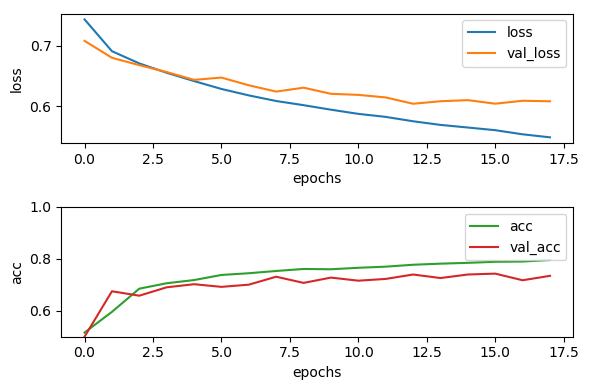

In [8]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_dense.png')

In [9]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 1s 107us/step
test_loss: 0.6168 - test_acc: 0.7394


In [10]:
# model.save_weights('embedding_dense.h5')

# Model \#3: Embedding + LSTM

In [11]:
from keras.layers import CuDNNLSTM

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(CuDNNLSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

Instructions for updating:
Use the retry module or similar alternatives.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 889, 64)           82752     
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 32)                12544     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 95,329
Trainable params: 95,329
Non-trainable params: 0
_________________________________________________________________


In [12]:
callbacks = [EarlyStopping(monitor='val_loss', patience=7)]

history = model.fit(X_train, y_train,
                    epochs=100,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/100
5284/5284 [==============================] - 5s 993us/step - loss: 0.6813 - acc: 0.5806 - val_loss: 0.6367 - val_acc: 0.6582
Epoch 2/100
5284/5284 [==============================] - 4s 803us/step - loss: 0.6120 - acc: 0.6764 - val_loss: 0.5718 - val_acc: 0.7211
Epoch 3/100
5284/5284 [==============================] - 4s 803us/step - loss: 0.5646 - acc: 0.7161 - val_loss: 0.5216 - val_acc: 0.7415
Epoch 4/100
5284/5284 [==============================] - 4s 802us/step - loss: 0.5250 - acc: 0.7417 - val_loss: 0.5209 - val_acc: 0.7568
Epoch 5/100
5284/5284 [==============================] - 4s 801us/step - loss: 0.5016 - acc: 0.7615 - val_loss: 0.4879 - val_acc: 0.7857
Epoch 6/100
5284/5284 [==============================] - 4s 808us/step - loss: 0.4810 - acc: 0.7695 - val_loss: 0.5076 - val_acc: 0.7602
Epoch 7/100
5284/5284 [==============================] - 4s 804us/step - loss: 0.4735 - acc: 0.7720 - val_loss: 0.4787 - val_acc: 0

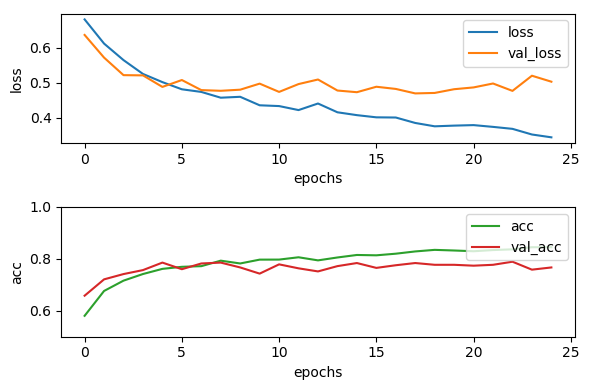

In [13]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_LSTM.png')

In [14]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 7s 1ms/step
test_loss: 0.5227 - test_acc: 0.7638


In [15]:
model.save_weights(root+'lstm.h5')

# Model \#4: Embedding + Conv1D + LSTM

In [16]:
from keras.layers import Conv1D

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(Conv1D(64, 5, activation='relu'))
model.add(CuDNNLSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 889, 64)           82752     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 885, 64)           20544     
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 32)                12544     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 115,873
Trainable params: 115,873
Non-trainable params: 0
_________________________________________________________________


In [17]:
callbacks = [EarlyStopping(monitor='val_loss', patience=7)]

history = model.fit(X_train, y_train,
                    epochs=300,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/300
5284/5284 [==============================] - 6s 1ms/step - loss: 0.6517 - acc: 0.6243 - val_loss: 0.5846 - val_acc: 0.7228
Epoch 2/300
5284/5284 [==============================] - 5s 941us/step - loss: 0.5800 - acc: 0.7017 - val_loss: 0.6506 - val_acc: 0.6224
Epoch 3/300
5284/5284 [==============================] - 5s 941us/step - loss: 0.5602 - acc: 0.7192 - val_loss: 0.5364 - val_acc: 0.7415
Epoch 4/300
5284/5284 [==============================] - 5s 944us/step - loss: 0.5386 - acc: 0.7356 - val_loss: 0.5365 - val_acc: 0.7602
Epoch 5/300
5284/5284 [==============================] - 5s 948us/step - loss: 0.5208 - acc: 0.7434 - val_loss: 0.5262 - val_acc: 0.7262
Epoch 6/300
5284/5284 [==============================] - 5s 948us/step - loss: 0.5111 - acc: 0.7530 - val_loss: 0.5399 - val_acc: 0.7551
Epoch 7/300
5284/5284 [==============================] - 5s 945us/step - loss: 0.4996 - acc: 0.7600 - val_loss: 0.5241 - val_acc: 0.7

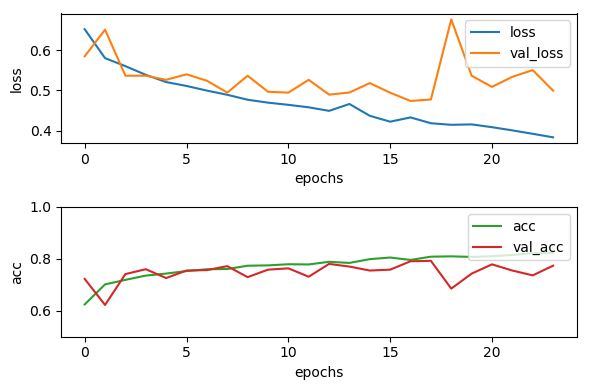

In [18]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_convLSTM.png')

In [19]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 7s 1ms/step
test_loss: 0.5354 - test_acc: 0.7534


In [20]:
model.save_weights(root+'conv_lstm.h5')

# Model \#7: Embedding + BiLSTM

In [21]:
from keras.layers import Bidirectional

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(Bidirectional(CuDNNLSTM(32)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 889, 64)           82752     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                25088     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 107,905
Trainable params: 107,905
Non-trainable params: 0
_________________________________________________________________


In [22]:
callbacks = [EarlyStopping(monitor='val_loss', patience=7)]

history = model.fit(X_train, y_train,
                    epochs=300,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/300
5284/5284 [==============================] - 9s 2ms/step - loss: 0.6637 - acc: 0.6166 - val_loss: 0.6065 - val_acc: 0.6888
Epoch 2/300
5284/5284 [==============================] - 8s 2ms/step - loss: 0.6046 - acc: 0.6836 - val_loss: 0.5756 - val_acc: 0.7143
Epoch 3/300
5284/5284 [==============================] - 8s 2ms/step - loss: 0.5728 - acc: 0.7106 - val_loss: 0.5310 - val_acc: 0.7449
Epoch 4/300
5284/5284 [==============================] - 8s 2ms/step - loss: 0.5529 - acc: 0.7193 - val_loss: 0.5164 - val_acc: 0.7500
Epoch 5/300
5284/5284 [==============================] - 8s 2ms/step - loss: 0.5413 - acc: 0.7335 - val_loss: 0.5975 - val_acc: 0.6803
Epoch 6/300
5284/5284 [==============================] - 8s 2ms/step - loss: 0.5209 - acc: 0.7455 - val_loss: 0.5416 - val_acc: 0.7228
Epoch 7/300
5284/5284 [==============================] - 8s 2ms/step - loss: 0.5067 - acc: 0.7498 - val_loss: 0.5135 - val_acc: 0.7619
Epoch 8/

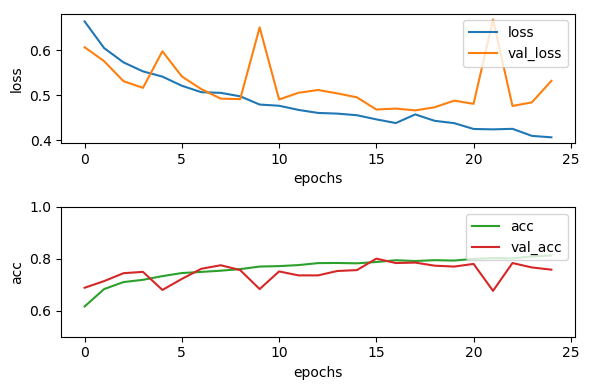

In [23]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'embedding_bilstm.png')

In [24]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 14s 2ms/step
test_loss: 0.5824 - test_acc: 0.7628


In [25]:
# model.save_weights('embedding_bilstm.h5')

# Model \#8: Embedding + Conv1D + BiLSTM

In [26]:
from keras.optimizers import Adam
from keras.layers import MaxPooling1D

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(Conv1D(128, 10, activation='relu'))
model.add(MaxPooling1D(5, 1))
model.add(Bidirectional(CuDNNLSTM(32)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',#Adam(lr=1e-5, decay=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 889, 64)           82752     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 880, 128)          82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 876, 128)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41472     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 206,337
Trainable params: 206,337
Non-trainable params: 0
_________________________________________________________________


In [27]:
callbacks = [EarlyStopping(monitor='val_loss', patience=7)] 

history = model.fit(X_train, y_train,
                    epochs=500,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/500
5284/5284 [==============================] - 12s 2ms/step - loss: 0.6445 - acc: 0.6302 - val_loss: 0.6035 - val_acc: 0.6769
Epoch 2/500
5284/5284 [==============================] - 11s 2ms/step - loss: 0.5873 - acc: 0.6934 - val_loss: 0.5514 - val_acc: 0.7296
Epoch 3/500
5284/5284 [==============================] - 11s 2ms/step - loss: 0.5612 - acc: 0.7156 - val_loss: 0.5675 - val_acc: 0.7058
Epoch 4/500
5284/5284 [==============================] - 11s 2ms/step - loss: 0.5449 - acc: 0.7271 - val_loss: 0.5246 - val_acc: 0.7466
Epoch 5/500
5284/5284 [==============================] - 11s 2ms/step - loss: 0.5254 - acc: 0.7449 - val_loss: 0.5211 - val_acc: 0.7483
Epoch 6/500
5284/5284 [==============================] - 11s 2ms/step - loss: 0.5103 - acc: 0.7506 - val_loss: 0.5198 - val_acc: 0.7449
Epoch 7/500
5284/5284 [==============================] - 11s 2ms/step - loss: 0.4884 - acc: 0.7742 - val_loss: 0.5595 - val_acc: 0.7160
E

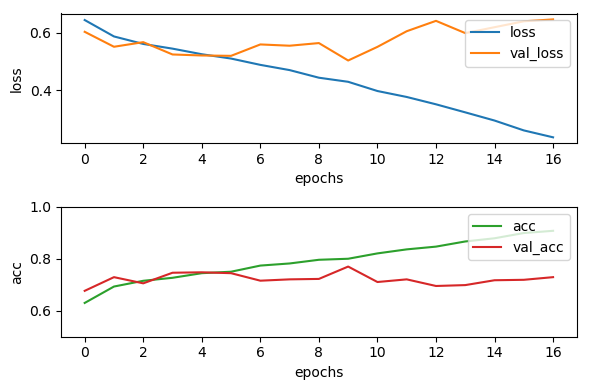

In [28]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_conv_bilstm.png')

In [29]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 15s 3ms/step
test_loss: 0.6981 - test_acc: 0.7190


# Model \#: 10

In [ ]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(n_feat, 64, input_length=maxlen))
model.add(Bidirectional(LSTM(32, recurrent_dropout=0.25, dropout=0.25)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 889, 64)           82752     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 107,649
Trainable params: 107,649
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=15)] 

history = model.fit(X_train, y_train,
                    epochs=100,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/100
5284/5284 [==============================] - 131s 25ms/step - loss: 0.6775 - acc: 0.5942 - val_loss: 0.6352 - val_acc: 0.7041
Epoch 2/100
5284/5284 [==============================] - 125s 24ms/step - loss: 0.6253 - acc: 0.6758 - val_loss: 0.5759 - val_acc: 0.7075
Epoch 3/100
5284/5284 [==============================] - 126s 24ms/step - loss: 0.5863 - acc: 0.7046 - val_loss: 0.5502 - val_acc: 0.7330
Epoch 4/100
5284/5284 [==============================] - 124s 23ms/step - loss: 0.5718 - acc: 0.7123 - val_loss: 0.5362 - val_acc: 0.7551
Epoch 5/100
 640/5284 [==>...........................] - ETA: 1:41 - loss: 0.5590 - acc: 0.7031

In [ ]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_dropout_LSTM.png')

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))